In [2]:
%matplotlib widget

### Global inflation factor dynamics

I try to model a series of global inflation observations as a combination of factors and therefore see what the impact of a global factor is on each local inflation print. This will be done again with a Dynamic Factor model, which is a Kalman Filter.
The data here for simplicity comes entirely from the FRED database.
For some countries I use OECD data that FRED provides, to be considered whether using OECD data for every country is possibly more consistent or if other measures of inflation are faster to show up. Possibly other datareaders are more suitable than the Fred datareader here.

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from fredapi import Fred as FredApi

fred = FredApi(api_key='0dfcbb403eea7fee006f01e935be9216')

cpi_us = fred.get_series_latest_release('CPIAUCSL')
cpi_eu = fred.get_series_latest_release('CP0000EZ19M086NEST')
# OECD data below... may not be aligned on the latest available and some are even quarterly
cpi_uk = fred.get_series_latest_release('GBRCPIALLMINMEI')
cpi_ca = fred.get_series_latest_release('CANCPIALLMINMEI')
cpi_au = fred.get_series_latest_release('AUSCPIALLQINMEI')
cpi_nz = fred.get_series_latest_release('NZLCPIALLQINMEI')
cpi_jp = fred.get_series_latest_release('JPNCPIALLMINMEI')

In [3]:
# now bring data together in a single dataframe.
# the index of the CPI_US series is likely the longest with data available, use that
index = cpi_us.index
cpi_us.name = 'US'
cpi_eu = cpi_eu.reindex_like(cpi_us)
cpi_eu.name = 'EU'
cpi_uk = cpi_uk.reindex_like(cpi_us)
cpi_uk.name = 'GB'
cpi_ca = cpi_ca.reindex_like(cpi_us)
cpi_ca.name = 'CA'
cpi_au = cpi_au.reindex_like(cpi_us).shift(-1)
cpi_au.name = 'AU'
cpi_nz = cpi_nz.reindex_like(cpi_us).shift(-1)
cpi_nz.name = 'NZ'
cpi_jp = cpi_jp.reindex_like(cpi_us)
cpi_jp.name = 'JP'

cpi_all = pd.concat([cpi_us, cpi_eu, cpi_uk, cpi_ca, cpi_au, cpi_nz, cpi_jp], axis=1).resample('M').last()
cpi_all_yoy = cpi_all.pct_change(periods=12, fill_method=None)*100
cpi_all_yoy = cpi_all_yoy.dropna(how="all", axis=0)
cpi_all_yoy_pca = cpi_all_yoy.dropna(how='any',axis=0)

In [4]:
cpi_all_yoy.tail(10)

,US,EU,GB,CA,AU,NZ,JP
2021-06-30,5.341016,1.901788,2.389706,3.061224,3.012048,4.933586,-0.400400
2021-07-31,5.276105,2.164831,2.014652,3.717201,NaN,NaN,-0.300000
2021-08-31,5.205332,2.955759,3.033088,4.087591,NaN,NaN,-0.399600
2021-09-30,5.389907,3.363186,2.930403,4.382761,3.498294,5.949008,0.200200
2021-10-31,6.236941,4.051355,3.846154,4.654545,NaN,NaN,0.100200
2021-11-30,6.828372,4.866412,4.582951,4.720407,NaN,NaN,0.603015
2021-12-31,7.096542,4.964337,4.844607,4.803493,NaN,NaN,0.805639
2022-01-31,7.525934,5.108242,4.849039,5.137482,NaN,NaN,0.501002
2022-02-28,7.912024,5.874550,5.484461,5.687545,NaN,NaN,0.901804
2022-03-31,8.557586,7.443913,NaN,NaN,NaN,NaN,NaN


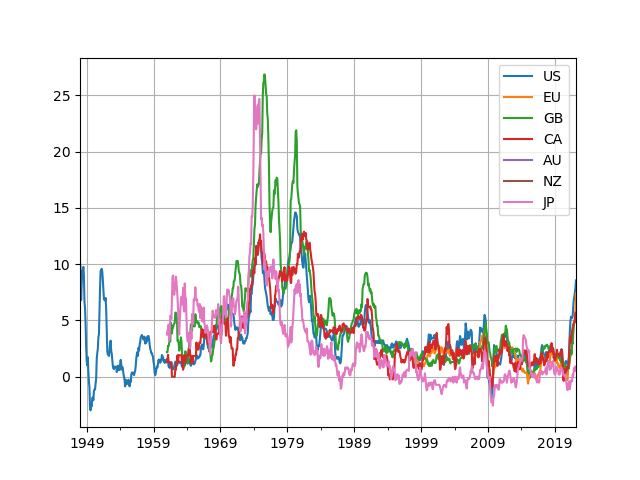

In [5]:
cpi_all_yoy.plot(grid=True);

Now that we have data organised properly, we can start considering the model.
Now... from when do we consider the model and to when?
For many central banks inflation targeting started at the end of the 80s, beginning of the 90s and the hyperinflation of the 80s had been under control for a few years.
You may be thinking that you are making a mistake as the world order is being now dismantled and inflation will stay elevated or will not follow a similar course as our prior 30 years... like inflationary forces from reversal of the globalisation... but realistically I doubt it.
So I shall consider a "data_from" of approximately 1985.
As to the data_to... one 

In [6]:
import statsmodels.api as sm

factors = ["global"]
factor_orders = 12
factor_multiplicities = None
standardize = True
idiosyncratic_ar1 = False
data_from = '1990'
data_to = '2021'

mod_gif = sm.tsa.DynamicFactorMQ(cpi_all_yoy.loc[data_from:data_to, :], factors=factors, \
                                 factor_orders=factor_orders, factor_multiplicities=factor_multiplicities, \
                                 standardize=standardize, idiosyncratic_ar1=idiosyncratic_ar1)
print(mod_gif.summary())

                         Model Specification: Dynamic Factor Model                         
Model:                Dynamic Factor Model   # of observed variables:                     7
                   + 1 factors in 1 blocks   # of factors:                                1
                       + iid idiosyncratic   Idiosyncratic disturbances:                iid
Sample:                1990-01-31 00:00:00   Standardize variables:                    True
                     - 2021-12-31 00:00:00                                                 
Observed variables / factor loadings
Dep. variable     global
------------------------
           US       X   
           EU       X   
           GB       X   
           CA       X   
           AU       X   
           NZ       X   
           JP       X   
    Factor blocks:   
     block      order
---------------------
    global         12


In [7]:
mod_res = mod_gif.fit(maxiter=1000)
print(mod_res.summary())

                               Dynamic Factor Results                              
Dep. Variable:            "US", and 6 more   No. Observations:                  384
Model:                Dynamic Factor Model   Log Likelihood               -1862.177
                   + 1 factors in 1 blocks   AIC                           3778.353
                       + iid idiosyncratic   BIC                           3885.020
Date:                     Sun, 24 Apr 2022   HQIC                          3820.662
Time:                             20:32:12   EM Iterations                      640
Sample:                         01-31-1990                                         
                              - 12-31-2021                                         
Covariance Type:              Not computed                                         
        Observation equation:         
Factor loadings:     global       var.
--------------------------------------
              US      -0.36       0.44
    

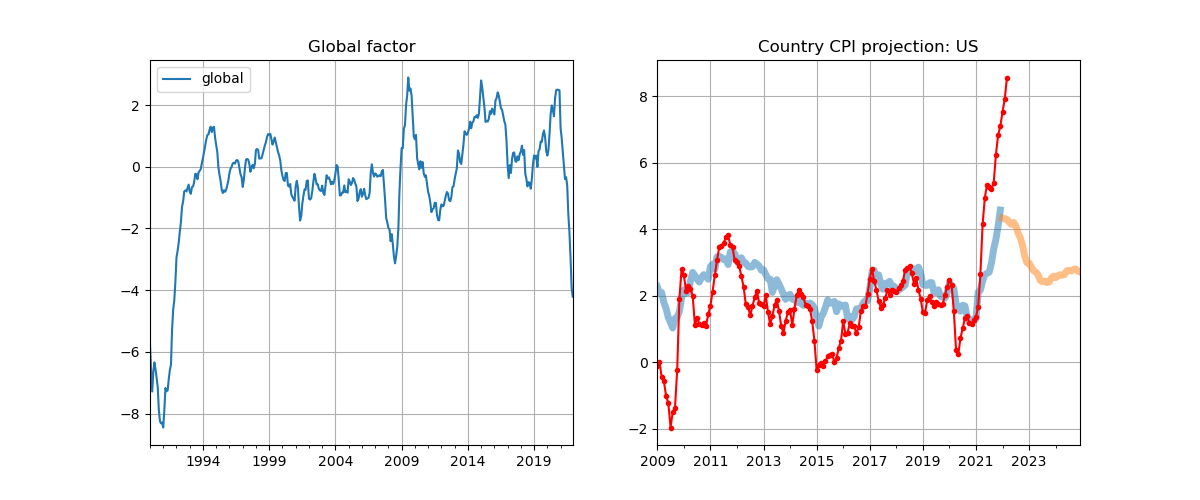

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5));
mod_res.factors['filtered'].loc[data_from:].plot(grid=True, ax=ax[0]);
mod_res_filtered_results = mod_res.predict()
# make a prediction 3y = 36 steps/months into future
mod_res_predictions = mod_res.forecast(36)
ax[0].set_title('Global factor')
data_from_chart = '2009'
country = 'US'
mod_res_filtered_results.loc[data_from_chart:data_to, country].plot(grid=True, ax=ax[1], linewidth=5, alpha=0.5);
cpi_all_yoy.loc[data_from_chart:,country].dropna().plot(grid=True, ax=ax[1], style='r.-');
mod_res_predictions.loc[data_from_chart:, country].plot(grid=True, ax=ax[1], linewidth=5, alpha=0.5);
ax[1].set_title('Country CPI projection: ' + country);

In [9]:
mod_res_filtered_results.tail()

,US,EU,GB,CA,AU,NZ,JP
2021-08-31,2.987893,2.505266,3.220804,2.516210,2.889345,2.492822,0.726581
2021-09-30,3.406863,3.193886,3.823550,2.925462,3.209555,2.792350,0.966107
2021-10-31,3.695220,3.667832,4.238394,3.207131,3.429941,2.998503,1.130963
2021-11-30,4.088793,4.314710,4.804603,3.591575,3.730740,3.279875,1.355970
2021-12-31,4.575160,5.114104,5.504310,4.066661,4.102460,3.627586,1.634028


In [10]:
mod_res_predictions.head()

,US,EU,GB,CA,AU,NZ,JP
2022-01-31,4.336707,4.722181,5.161262,3.833738,3.920215,3.457112,1.497703
2022-02-28,4.312831,4.682939,5.126913,3.810416,3.901967,3.440043,1.484054
2022-03-31,4.291740,4.648273,5.096570,3.789814,3.885848,3.424964,1.471996
2022-04-30,4.208786,4.511930,4.977230,3.708785,3.822448,3.365659,1.424571
2022-05-31,4.143452,4.404547,4.883238,3.644967,3.772515,3.318951,1.387219
